In [2]:
# general packages
import os
import numpy as np
import pandas as pd

# image-related packages
import seaborn as sns
import cv2
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib.image import imread
from matplotlib import pyplot as plt

# tensorflow 2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# this line is needed for Mac OS
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
print("tensorflow: ", tf.__version__)
print("cv2: ", cv2.__version__, "\n")

#for i in range(len(tf.config.list_physical_devices())):
#    print(tf.config.list_physical_devices()[i])

tensorflow:  2.0.0
cv2:  3.4.2 



In [7]:
ls -ltrh ./data/*.mov

-rwxrwxrwx@ 1 bogdan  staff   630M Feb 16 14:16 ./data/zero-to-five.mov*
-rw-r--r--@ 1 bogdan  staff   291M Mar 24 09:59 ./data/zero-to-five-new.mov


In [8]:
# extract jpeg frames from .mov file: already done

# vidcap = cv2.VideoCapture('./Data/zero-to-five.mov')
# success,image = vidcap.read()
# count = 0

# while success:
#     cv2.imwrite("./Data/frame%d.jpg" % count, image)     # save frame as JPEG file      
#     success,image = vidcap.read()
#     if count%30 == 0:  # 30 frames per second for .mov video file
#         print('Reading the frame: ', count)
#     count += 1

# print('The last frame is: ', count)

In [9]:
# move manually the extracted frames to corresponding categories
# bases on frame number and time used for recording the 0 to 5 signs

In [10]:
# move 30% of all jpgs from /train to corresponding /test categories
# by simply moving to /test all frames that end with digits 0, 4 and 7

# mv ./data/train/0/*0.jpg ./data/test/0/
# mv ./data/train/0/*4.jpg ./data/test/0/
# mv ./data/train/0/*7.jpg ./data/test/0/
# mv ./data/train/1/*0.jpg ./data/test/1/
# mv ./data/train/1/*4.jpg ./data/test/1/
# mv ./data/train/1/*7.jpg ./data/test/1/
# mv ./data/train/2/*0.jpg ./data/test/2/
# mv ./data/train/2/*4.jpg ./data/test/2/
# mv ./data/train/2/*7.jpg ./data/test/2/
# mv ./data/train/3/*0.jpg ./data/test/3/
# mv ./data/train/3/*4.jpg ./data/test/3/
# mv ./data/train/3/*7.jpg ./data/test/3/
# mv ./data/train/4/*0.jpg ./data/test/4/
# mv ./data/train/4/*4.jpg ./data/test/4/
# mv ./data/train/4/*7.jpg ./data/test/4/
# mv ./data/train/5/*0.jpg ./data/test/5/
# mv ./data/train/5/*4.jpg ./data/test/5/
# mv ./data/train/5/*7.jpg ./data/test/5/

In [9]:
!du -h ./data/train

425M	./data/train/5
481M	./data/train/4
489M	./data/train/2
515M	./data/train/1
489M	./data/train/3
2,4G	./data/train


In [10]:
!du -h ./data/test

185M	./data/test/5
208M	./data/test/4
213M	./data/test/2
225M	./data/test/1
213M	./data/test/3
1,1G	./data/test


In [11]:
!find ./data/train -maxdepth 1 -type d -print0 | xargs -0 -I {} sh -c 'echo $(find {} | wc -l) {}' | sort -n

2864 ./data/train/5
3137 ./data/train/4
3273 ./data/train/2
3283 ./data/train/3
3521 ./data/train/1
16081 ./data/train


In [12]:
!find ./data/test -maxdepth 1 -type d -print0 | xargs -0 -I {} sh -c 'echo $(find {} | wc -l) {}' | sort -n

1226 ./data/test/5
1337 ./data/test/4
1401 ./data/test/2
1409 ./data/test/3
1512 ./data/test/1
6888 ./data/test


After moving train and test data to corresponding classes, there are:

- 10068 training jpgs (including 6 directories so total = 10061)
- 4310 test jpgs (including 6 directories so total = 4303)
- 1.3 GB used for training jpgs
- 572 MB used for test jpgs

The number of files for each of the 5 classes in /train and /test is relatively equal with the exception of the classes 4 and 5 where I had to delete more jpgs due to recording issues.

In [15]:
# This function will plot training images in the form of a grid with 1 row and 5 columns 
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [16]:
samples=[]
#samples.append(imread('./data/train/0/frame16768.jpg')) # sample class 0 -- class 0 was removed
samples.append(imread('./data/train/1/frame10118.jpg')) # sample class 1
samples.append(imread('./data/train/2/frame1.jpg')) # sample class 2
samples.append(imread('./data/train/3/frame3398.jpg')) # sample class 3
samples.append(imread('./data/train/4/frame6765.jpg')) # sample class 4
samples.append(imread('./data/train/5/frame13421.jpg')) # sample class 5

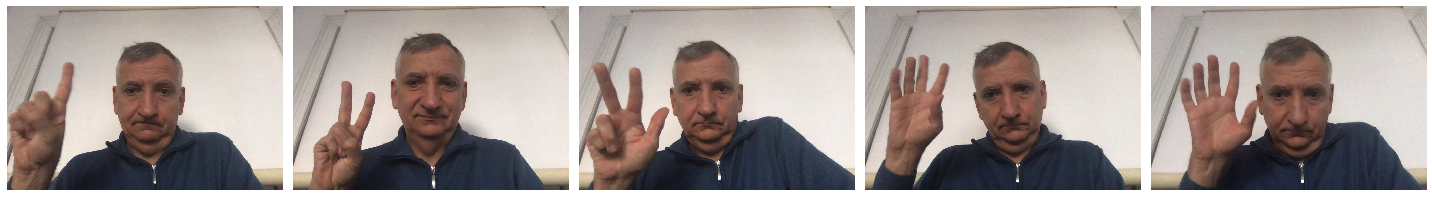

In [17]:
# Print the classes inside each jpeg sample
#font      = cv2.FONT_HERSHEY_SIMPLEX
#position  = (20,700)
#fontScale = 2
#fontColor = (255,255,255)
#lineType  = 5

#cv2.putText(samples[0], 'Class: 0', position, font, fontScale, fontColor, lineType)  -- class 0 was removed
#cv2.putText(samples[0], 'Class: 1', position, font, fontScale, fontColor, lineType)
#cv2.putText(samples[1], 'Class: 2', position, font, fontScale, fontColor, lineType)
#cv2.putText(samples[2], 'Class: 3', position, font, fontScale, fontColor, lineType)
#cv2.putText(samples[3], 'Class: 4', position, font, fontScale, fontColor, lineType)
#cv2.putText(samples[4], 'Class: 5', position, font, fontScale, fontColor, lineType)

plotImages(samples)

In [18]:
# parameters
train_dir = './data/train'
test_dir = './data/test'
batch_size = 16
epochs = 10
# will rescale all jpeg images to 255x255 for having a reasonable time for the training
IMG_HEIGHT = 255
IMG_WIDTH = 255

image_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

In [19]:
image_gen = ImageDataGenerator(rotation_range=10, # randomly rotate the image with <=10 degrees
                               #width_shift_range=0.10, # Shift the pic width by a max of 10%
                               #height_shift_range=0.10, # Shift the pic height by a max of 10%
                               rescale=1/255, # Normalize the image
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [20]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH)
                                              )

Found 16073 images belonging to 5 classes.


In [21]:
test_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                              directory=test_dir,
                                              shuffle=True,
                                              target_size=(IMG_HEIGHT, IMG_WIDTH)
                                             )

Found 6880 images belonging to 5 classes.


The number of /train images is 10061, the number of /test images is 4303, as counted earlier with the bash commands

In [22]:
sample_training_images, sample_training_labels = next(train_data_gen)

In [23]:
# This function will plot images in the form of a grid with 1 row and 5 columns 
# where images are placed in each column.
def plotImages(images_arr, labels_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    i=1
    for label in labels_arr:
        print("Image", i, " one-hot encoded class:", label)
        i+=1

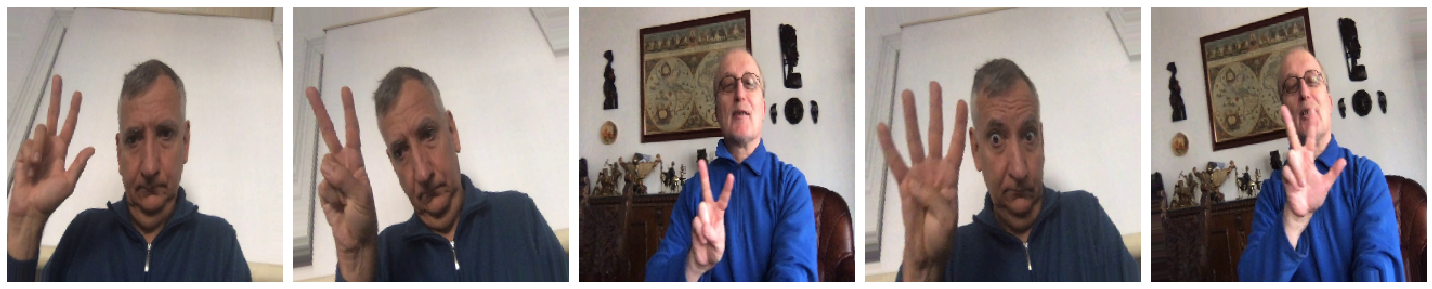

Image 1  one-hot encoded class: [0. 0. 1. 0. 0.]
Image 2  one-hot encoded class: [0. 1. 0. 0. 0.]
Image 3  one-hot encoded class: [0. 1. 0. 0. 0.]
Image 4  one-hot encoded class: [0. 0. 0. 1. 0.]
Image 5  one-hot encoded class: [0. 0. 1. 0. 0.]


In [24]:
plotImages(sample_training_images[:5], sample_training_labels[:5])

ImageDataGenerator did the following:

- rotated the image by no more than of +- 20%
- no horizontal or vertical shift because the hand is close to one edge in some jpgs
- normalized the 0...255 values to the float interval 0...1
- rescaled the image to 255 x 255 pixels
- returned the image itself and the one-hot encoded class based on the class directory

# Model 1, one Conv2D layer, 16 filters

In [30]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
#use patience=2 since the data and the CNN model itself is noisy
# and may have a decreased performance for one epoch

In [31]:
model1 = Sequential()

model1.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', input_shape=image_shape, activation='relu'))
model1.add(MaxPooling2D(pool_size=(3, 3)))
#model1.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
#model1.add(MaxPooling2D(pool_size=(3, 3)))
#model1.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
#model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())

model1.add(Dense(255))
model1.add(Activation('relu'))

model1.add(Dense(5, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [32]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 255, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 115600)            0         
_________________________________________________________________
dense (Dense)                (None, 255)               29478255  
_________________________________________________________________
activation (Activation)      (None, 255)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1280      
Total params: 29,479,983
Trainable params: 29,479,983
Non-trainable params: 0
____________________________________________

In [33]:
history = model1.fit(train_data_gen,
                     epochs=epochs,
                     validation_data=test_data_gen,
                     callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1005 steps, validate for 430 steps
Epoch 1/10
1005/1005 [==============================] - 383s 381ms/step - loss: 0.8625 - accuracy: 0.6885 - val_loss: 0.5052 - val_accuracy: 0.8110
Epoch 2/10
1005/1005 [==============================] - 381s 379ms/step - loss: 0.3666 - accuracy: 0.8630 - val_loss: 0.2530 - val_accuracy: 0.9022
Epoch 3/10
1005/1005 [==============================] - 382s 381ms/step - loss: 0.2407 - accuracy: 0.9119 - val_loss: 0.1568 - val_accuracy: 0.9404
Epoch 4/10
1005/1005 [==============================] - 382s 380ms/step - loss: 0.1678 - accuracy: 0.9414 - val_loss: 0.2233 - val_accuracy: 0.9314
Epoch 5/10
1005/1005 [==============================] - 380s 378ms/step - loss: 0.1245 - accuracy: 0.9566 - val_loss: 0.0961 - val_accuracy: 0.9669
Epoch 6/10
1005/1005 [==============================] - 381s 379ms/step - loss: 0.0999 - accuracy: 0.9659 - val_loss: 0.0944 - val_accuracy: 0.9674
Epoch 7/10
1005/1

In [34]:
model1.save('model1-one-CNN-layer-16-filters.h5')

In [66]:
#model1 = load_model('model1-one-CNN-layer-16-filters.h5')

In [67]:
losses_model1 = pd.DataFrame(model1.history.history)
losses_model1

,loss,accuracy,val_loss,val_accuracy
0,0.862150,0.688546,0.505167,0.811047
1,0.366540,0.863000,0.253028,0.902180
2,0.240612,0.911902,0.156823,0.940407
3,0.167783,0.941392,0.223297,0.931395
4,0.124455,0.956573,0.096077,0.966860
5,0.099905,0.965906,0.094429,0.967442
6,0.088094,0.973247,0.105976,0.970785
7,0.077772,0.977727,0.031741,0.989826
8,0.073561,0.979842,0.054033,0.980378
9,0.054057,0.984881,0.027891,0.991279


In [38]:
print(model1.metrics_names)
print(model1.evaluate(test_data_gen,verbose=0))

['loss', 'accuracy']
  ...
    to  
  ['...']
[0.030571298635703008, 0.9905523]


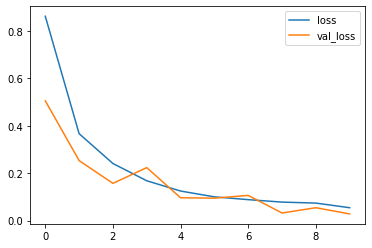

In [39]:
losses_model1[['loss','val_loss']].plot()

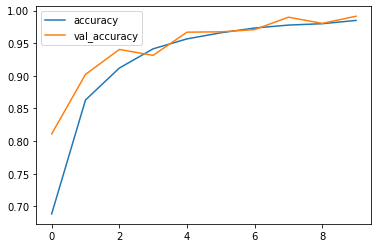

In [40]:
losses_model1[['accuracy','val_accuracy']].plot()

In [42]:
test_images, test_labels = next(test_data_gen)

In [46]:
labels = []
for result in test_labels:
    labels.append(np.where(result == 1)[0][0])
labels = np.asarray(labels)

In [47]:
predictions = model1.predict_classes(test_images)

In [48]:
print("labels type:", type(labels), "predictions type:", type(predictions))

labels type: <class 'numpy.ndarray'> predictions type: <class 'numpy.ndarray'>


In [50]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      0.88      0.93         8
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         1

    accuracy                           0.94        16
   macro avg       0.95      0.97      0.96        16
weighted avg       0.95      0.94      0.94        16



In [51]:
confusion_matrix(labels, predictions)

array([[2, 0, 0, 0, 0],
       [0, 2, 0, 0, 0],
       [0, 0, 7, 1, 0],
       [0, 0, 0, 3, 0],
       [0, 0, 0, 0, 1]])

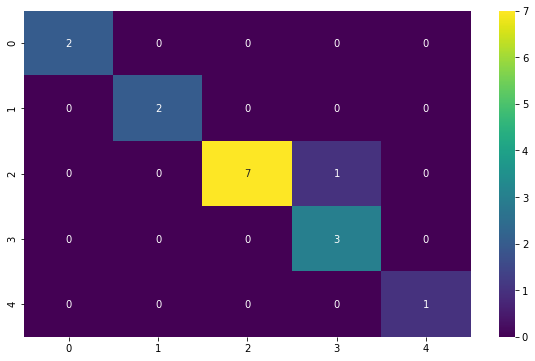

In [57]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(labels, predictions), cmap='viridis', annot=True)

In [ ]:
# For the first batch of 16 images, all the classes were correctly predicted with one exception.
# Accuracy for this batch was 94%

In [58]:
# I shall test the model on pictures from different people, dressed differently, using different backgrounds.
# A problem is that the train and test datasets were taken in very similar conditions
# and if conditions change, the results will get worse.

In [44]:
test1_dir = './data/test1'
batch_size = 200
test1_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=test1_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH)
                                              )

Found 200 images belonging to 5 classes.


In [61]:
test1_images, test1_labels = next(test1_data_gen)

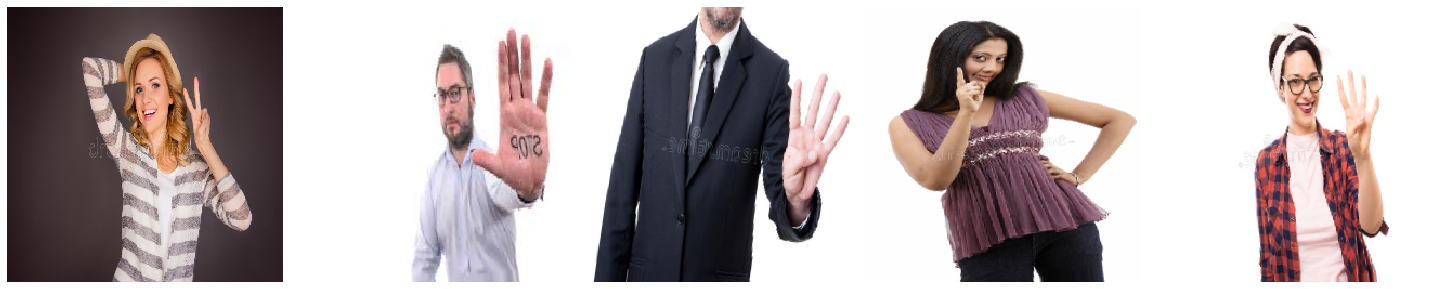

Image 1  one-hot encoded class: [0. 1. 0. 0. 0.]
Image 2  one-hot encoded class: [0. 0. 0. 0. 1.]
Image 3  one-hot encoded class: [0. 0. 0. 1. 0.]
Image 4  one-hot encoded class: [1. 0. 0. 0. 0.]
Image 5  one-hot encoded class: [0. 0. 0. 1. 0.]


In [62]:
plotImages(test1_images[:5], test1_labels[:5])

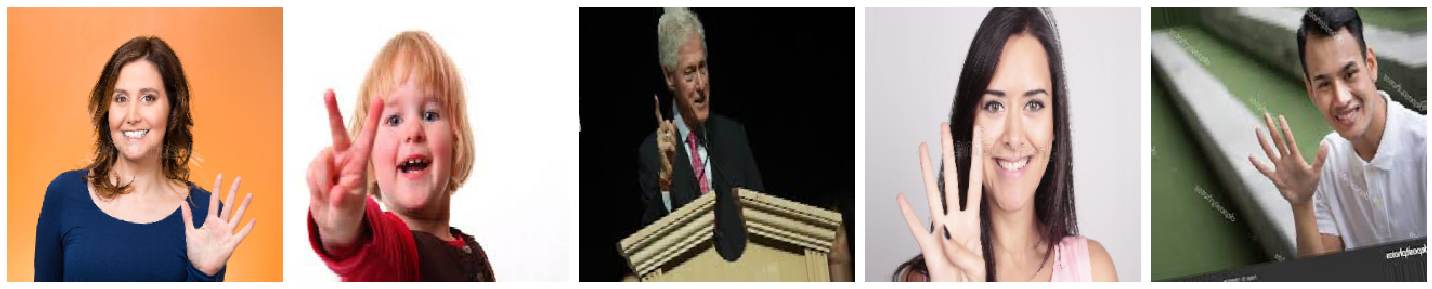

Image 1  one-hot encoded class: [0. 0. 0. 0. 1.]
Image 2  one-hot encoded class: [0. 1. 0. 0. 0.]
Image 3  one-hot encoded class: [1. 0. 0. 0. 0.]
Image 4  one-hot encoded class: [0. 0. 0. 1. 0.]
Image 5  one-hot encoded class: [0. 0. 0. 0. 1.]


In [63]:
plotImages(test1_images[5:10], test1_labels[5:10])

In [65]:
predictions1 = model1.predict_classes(test1_images)

In [68]:
labels = []
for result in test1_labels:
    labels.append(np.where(result == 1)[0][0])
labels = np.asarray(labels)

In [70]:
print(classification_report(labels, predictions1))

              precision    recall  f1-score   support

           0       0.17      0.03      0.04        40
           1       0.30      0.30      0.30        40
           2       0.08      0.05      0.06        40
           3       0.29      0.23      0.25        40
           4       0.21      0.50      0.29        40

    accuracy                           0.22       200
   macro avg       0.21      0.22      0.19       200
weighted avg       0.21      0.22      0.19       200



In [71]:
confusion_matrix(labels, predictions1)

array([[ 1,  7, 10,  2, 20],
       [ 1, 12,  7,  7, 13],
       [ 1,  5,  2,  9, 23],
       [ 0,  6,  4,  9, 21],
       [ 3, 10,  3,  4, 20]])

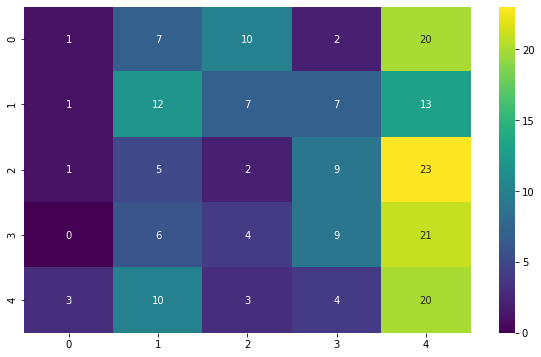

In [72]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(labels, predictions1), cmap='viridis', annot=True)

In [73]:
# the result is not too good, the 0.22 accuracy is marginally superior
# to the 0.2 accuracy for a random choice of one of the five classes
# From the heatmap it is clear that the model is biased towards class 4
# and to a lesser extent towards class 2 (that is 5 fingers and 2 fingers)

# Model 2, one Conv2D layer, 32 filters

In [33]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

model2 = Sequential()

model2.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=image_shape, activation='relu'))
model2.add(MaxPooling2D(pool_size=(3, 3)))
#model2.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
#model2.add(MaxPooling2D(pool_size=(3, 3)))
#model2.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
#model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())

model2.add(Dense(255))
model2.add(Activation('relu'))

model2.add(Dense(5, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [34]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 255, 255, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 231200)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 255)               58956255  
_________________________________________________________________
activation_1 (Activation)    (None, 255)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1280      
Total params: 58,958,431
Trainable params: 58,958,431
Non-trainable params: 0
__________________________________________

In [35]:
history = model2.fit_generator(train_data_gen,
                               epochs=epochs,
                               validation_data=test_data_gen,
                               callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1005 steps, validate for 430 steps
Epoch 1/10
1005/1005 [==============================] - 386s 384ms/step - loss: 1.5157 - accuracy: 0.6931 - val_loss: 0.4162 - val_accuracy: 0.8388
Epoch 2/10
1005/1005 [==============================] - 382s 380ms/step - loss: 0.2997 - accuracy: 0.8884 - val_loss: 0.2686 - val_accuracy: 0.9010
Epoch 3/10
1005/1005 [==============================] - 381s 379ms/step - loss: 0.1754 - accuracy: 0.9376 - val_loss: 0.1153 - val_accuracy: 0.9571
Epoch 4/10
1005/1005 [==============================] - 381s 379ms/step - loss: 0.1408 - accuracy: 0.9535 - val_loss: 0.1064 - val_accuracy: 0.9625
Epoch 5/10
1005/1005 [==============================] - 380s 378ms/step - loss: 0.1085 - accuracy: 0.9669 - val_loss: 0.0334 - val_accuracy: 0.9887
Epoch 6/10
1005/1005 [==============================] - 382s 380ms/step - loss: 0.0824 - accuracy: 0.9757 - val_loss: 0.0537 - val_accuracy: 0.9810
Epoch 7/10
1005/1

In [36]:
model2.save('model2-one-CNN-layer-32-filters.h5')

In [38]:
losses_model2 = pd.DataFrame(model2.history.history)
losses_model2

,loss,accuracy,val_loss,val_accuracy
0,1.515855,0.693088,0.416187,0.838808
1,0.299719,0.888446,0.268606,0.901017
2,0.175490,0.937597,0.115299,0.957122
3,0.140817,0.953525,0.106367,0.962500
4,0.108501,0.966901,0.033422,0.988663
5,0.082417,0.975673,0.053654,0.980959
6,0.071532,0.978971,0.025206,0.992006
7,0.065052,0.982020,0.027300,0.989680
8,0.059531,0.984384,0.015538,0.995058
9,0.047315,0.986001,0.023104,0.992733


In [39]:
print(model2.metrics_names)
print(model2.evaluate(test_data_gen,verbose=0))

['loss', 'accuracy']
  ...
    to  
  ['...']
[0.026389006760326024, 0.99331397]


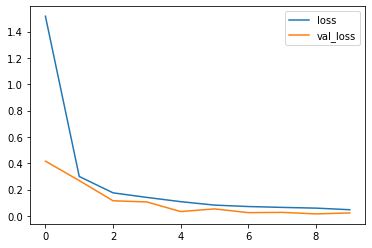

In [40]:
losses_model2[['loss','val_loss']].plot()

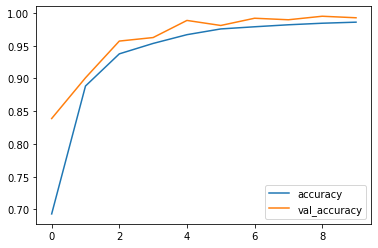

In [41]:
losses_model2[['accuracy','val_accuracy']].plot()

In [45]:
test1_images, test1_labels = next(test1_data_gen)

In [46]:
predictions2 = model2.predict_classes(test1_images)

In [47]:
labels = []
for result in test1_labels:
    labels.append(np.where(result == 1)[0][0])
labels = np.asarray(labels)

In [49]:
print(classification_report(labels, predictions2))

              precision    recall  f1-score   support

           0       0.12      0.03      0.04        40
           1       0.26      0.17      0.21        40
           2       0.11      0.10      0.11        40
           3       0.26      0.17      0.21        40
           4       0.24      0.62      0.35        40

    accuracy                           0.22       200
   macro avg       0.20      0.22      0.18       200
weighted avg       0.20      0.22      0.18       200



In [50]:
confusion_matrix(labels, predictions2)

array([[ 1,  8, 10,  2, 19],
       [ 2,  7, 10,  6, 15],
       [ 1,  5,  4,  9, 21],
       [ 1,  4,  5,  7, 23],
       [ 3,  3,  6,  3, 25]])

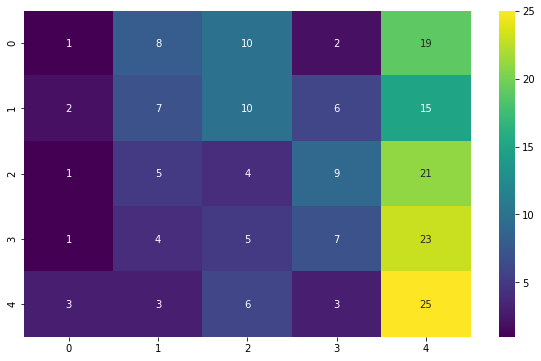

In [51]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(labels, predictions2), cmap='viridis', annot=True)

In [92]:
predicted_class, counts = np.unique(predictions2, return_counts=True)
df = pd.DataFrame(data = list(zip(predicted_class, counts)), columns=['Class', 'Predicted_number'])
df.set_index('Class')

,Predicted_number
Class,
0,8
1,27
2,35
3,27
4,103


In [77]:
# The overall performance of model2 is almost identical with the one for model 1
# but the predicted classes are not so biased towasds class 4
# It looks like one hidden CNN layer is not enough

# Model 3, two Conv2D layers with 16 and 32 filters

In [78]:
model3 = Sequential()

model3.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', input_shape=image_shape, activation='relu'))
model3.add(MaxPooling2D(pool_size=(3, 3)))
model3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(3, 3)))
#model3.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
#model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())

model3.add(Dense(255))
model3.add(Activation('relu'))

model3.add(Dense(5, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [79]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 255, 255, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 85, 85, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 85, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 255)               6397695   
_________________________________________________________________
activation_2 (Activation)    (None, 255)              

In [80]:
history = model3.fit_generator(train_data_gen,
                               epochs=epochs,
                               validation_data=test_data_gen,
                               callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1005 steps, validate for 430 steps
Epoch 1/10
1005/1005 [==============================] - 383s 381ms/step - loss: 0.7650 - accuracy: 0.7185 - val_loss: 0.3032 - val_accuracy: 0.8850
Epoch 2/10
1005/1005 [==============================] - 382s 380ms/step - loss: 0.2478 - accuracy: 0.9102 - val_loss: 0.1557 - val_accuracy: 0.9477
Epoch 3/10
1005/1005 [==============================] - 384s 382ms/step - loss: 0.1317 - accuracy: 0.9520 - val_loss: 0.0743 - val_accuracy: 0.9750
Epoch 4/10
1005/1005 [==============================] - 383s 381ms/step - loss: 0.0877 - accuracy: 0.9691 - val_loss: 0.1200 - val_accuracy: 0.9645
Epoch 5/10
1005/1005 [==============================] - 382s 380ms/step - loss: 0.0618 - accuracy: 0.9795 - val_loss: 0.0308 - val_accuracy: 0.9882
Epoch 6/10
1005/1005 [==============================] - 383s 381ms/step - loss: 0.0468 - accuracy: 0.9851 - val_loss: 0.0350 - val_accuracy: 0.9878
Epoch 7/10
1005/1

In [81]:
model3.save('model3-two-CNN-layers.h5')

In [ ]:
#model3 = load_model('model3-two-CNN-layers.h5')

In [83]:
losses_model3 = pd.DataFrame(model3.history.history)
losses_model3

,loss,accuracy,val_loss,val_accuracy
0,0.765175,0.718472,0.303236,0.885029
1,0.247799,0.910222,0.155721,0.947674
2,0.131679,0.952031,0.074280,0.975000
3,0.087723,0.969079,0.119967,0.964535
4,0.061700,0.979469,0.030838,0.988227
5,0.046856,0.985068,0.035018,0.987791
6,0.034033,0.988677,0.024530,0.991715
7,0.032687,0.990045,0.021841,0.993023
8,0.030713,0.991103,0.019397,0.993895
9,0.025255,0.992721,0.015280,0.993895


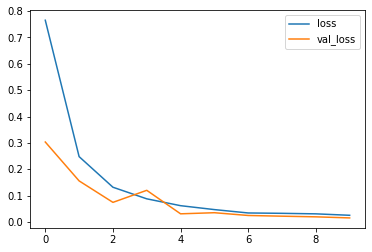

In [84]:
losses_model3[['loss','val_loss']].plot()

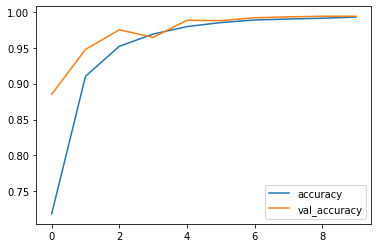

In [85]:
losses_model3[['accuracy','val_accuracy']].plot()

In [86]:
predictions3 = model3.predict_classes(test1_images)

In [87]:
labels = []
for result in test1_labels:
    labels.append(np.where(result == 1)[0][0])
labels = np.asarray(labels)

In [89]:
print(classification_report(labels, predictions3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.17      0.10      0.12        40
           2       0.11      0.07      0.09        40
           3       0.16      0.17      0.17        40
           4       0.20      0.53      0.29        40

    accuracy                           0.17       200
   macro avg       0.13      0.17      0.13       200
weighted avg       0.13      0.17      0.13       200



In [90]:
confusion_matrix(labels, predictions3)

array([[ 0,  2,  9,  8, 21],
       [ 0,  4,  4, 13, 19],
       [ 0,  6,  3, 10, 21],
       [ 0,  5,  6,  7, 22],
       [ 1,  7,  6,  5, 21]])

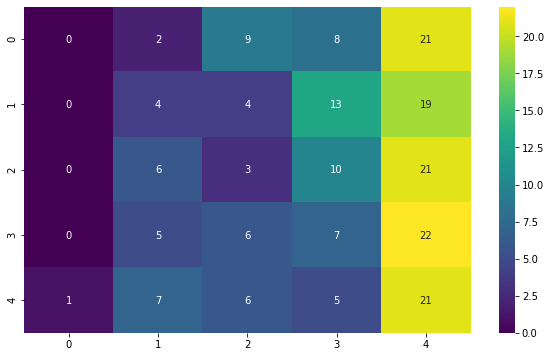

In [91]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(labels, predictions3), cmap='viridis', annot=True)

In [95]:
# The situation is worse than before, the accuracy is now 17%
# and the model is very biased towards class 4

# Next idea: use cv2.Canny function to detect edges

By using this function, the output shows (almost) only the edges:

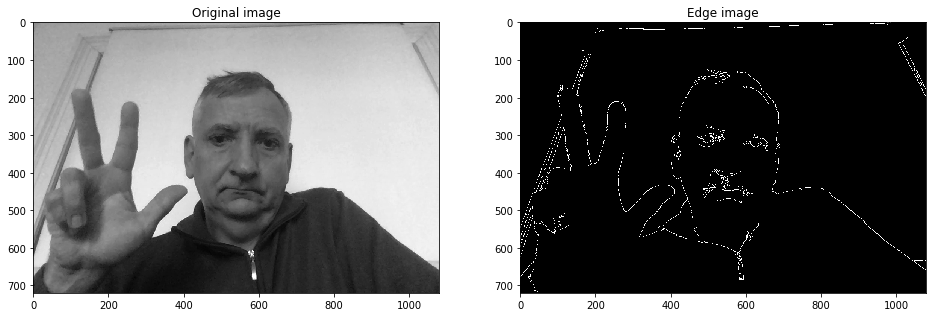

In [32]:
img1 = cv2.imread('./data/train/3/frame3508.jpg',0)
param1 = 20
param2 = 150
img_edges = cv2.Canny(img1,param1,param2)

plt.figure(figsize=(16,12))
plt.subplot(121),plt.imshow(img1, cmap='gray')
plt.title('Original image')
plt.subplot(122),plt.imshow(img_edges, cmap='gray')
plt.title('Edge image')

plt.show()

Create a similar /data directory with cv2.Canny applied, named /data_edges

The original /data directory is not modified

In [34]:
dir_source = './data/train/'
dir_dest = './data_edges/train/'
dir_list = ['1/', '2/', '3/', '4/', '5/']

In [35]:
param1 = 20
param2 = 150

for dir_list_item in dir_list:
    files_list = os.listdir(dir_source+dir_list_item)
    for file_name in files_list:
        img = cv2.imread(dir_source+dir_list_item+file_name,0)
        img_edges = cv2.Canny(img,param1,param2)
        cv2.imwrite(dir_dest+dir_list_item+file_name, img_edges)

In [37]:
dir_source = './data/test/'
dir_dest = './data_edges/test/'
dir_list = ['1/', '2/', '3/', '4/', '5/']

for dir_list_item in dir_list:
    files_list = os.listdir(dir_source+dir_list_item)
    for file_name in files_list:
        img = cv2.imread(dir_source+dir_list_item+file_name,0)
        img_edges = cv2.Canny(img,param1,param2)
        cv2.imwrite(dir_dest+dir_list_item+file_name, img_edges)

Continue by using the same steps as in the beginning

In [114]:
!du -h ./data/train

425M	./data/train/5
481M	./data/train/4
489M	./data/train/2
515M	./data/train/1
489M	./data/train/3
2,4G	./data/train


In [115]:
!du -h ./data_edges/train

482M	./data_edges/train/4
338M	./data_edges/train/2
466M	./data_edges/train/1
450M	./data_edges/train/3
1,7G	./data_edges/train


After applying cv2.Canny there is less information because only the edges are shown. Therefore, the jpg files can be compressed better and the overall size is reduced

In [119]:
!find ./data/train -maxdepth 1 -type d -print0 | xargs -0 -I {} sh -c 'echo $(find {} | wc -l) {}' | sort -n

2864 ./data/train/5
3137 ./data/train/4
3273 ./data/train/2
3283 ./data/train/3
3521 ./data/train/1
16079 ./data/train


In [122]:
!find ./data_edges/train -maxdepth 1 -type d -print0 | xargs -0 -I {} sh -c 'echo $(find {} | wc -l) {}' | sort -n

2864 ./data_edges/train/5
3137 ./data_edges/train/4
3273 ./data_edges/train/2
3283 ./data_edges/train/3
3521 ./data_edges/train/1
16079 ./data_edges/train


In [123]:
!find ./data/test -maxdepth 1 -type d -print0 | xargs -0 -I {} sh -c 'echo $(find {} | wc -l) {}' | sort -n

1226 ./data/test/5
1337 ./data/test/4
1401 ./data/test/2
1409 ./data/test/3
1512 ./data/test/1
6886 ./data/test


In [124]:
!find ./data_edges/test -maxdepth 1 -type d -print0 | xargs -0 -I {} sh -c 'echo $(find {} | wc -l) {}' | sort -n

1226 ./data_edges/test/5
1337 ./data_edges/test/4
1401 ./data_edges/test/2
1409 ./data_edges/test/3
1512 ./data_edges/test/1
6886 ./data_edges/test


The number of files for each class for /train and /test is the same

In [129]:
# This function will plot training images in the form of a grid with 1 row and 5 columns 
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [130]:
samples=[]
samples.append(imread('./data_edges/train/1/frame10118.jpg')) # sample class 1
samples.append(imread('./data_edges/train/2/frame1.jpg')) # sample class 2
samples.append(imread('./data_edges/train/3/frame3398.jpg')) # sample class 3
samples.append(imread('./data_edges/train/4/frame6765.jpg')) # sample class 4
samples.append(imread('./data_edges/train/5/frame13421.jpg')) # sample class 5

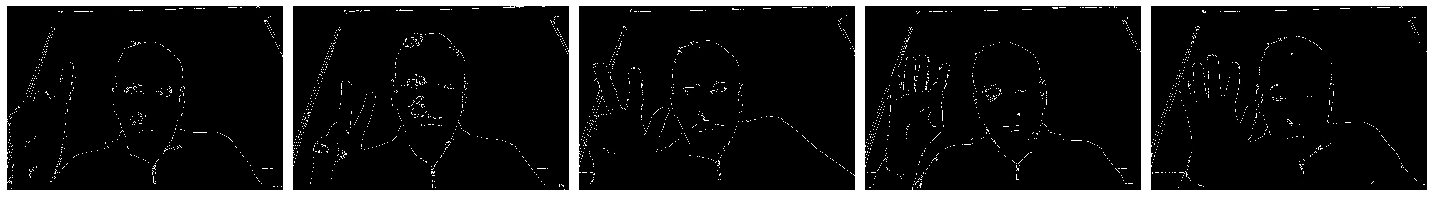

In [132]:
# Print the classes inside each jpeg sample
#font      = cv2.FONT_HERSHEY_SIMPLEX
#position  = (20,700)
#fontScale = 2
#fontColor = (255,255,255)
#lineType  = 5

#cv2.putText(samples[0], 'Class: 1', position, font, fontScale, fontColor, lineType)
#cv2.putText(samples[1], 'Class: 2', position, font, fontScale, fontColor, lineType)
#cv2.putText(samples[2], 'Class: 3', position, font, fontScale, fontColor, lineType)
#cv2.putText(samples[3], 'Class: 4', position, font, fontScale, fontColor, lineType)
#cv2.putText(samples[4], 'Class: 5', position, font, fontScale, fontColor, lineType)

plotImages(samples)

In [133]:
# parameters
train_dir = './data_edges/train'
test_dir = './data_edges/test'
batch_size = 16
epochs = 10
# will rescale all jpeg images to 255x255 for having a reasonable time for the training
IMG_HEIGHT = 255
IMG_WIDTH = 255

image_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

In [134]:
image_gen = ImageDataGenerator(rotation_range=10, # randomly rotate the image with <=10 degrees
                               #width_shift_range=0.10, # Shift the pic width by a max of 10%
                               #height_shift_range=0.10, # Shift the pic height by a max of 10%
                               rescale=1/255, # Normalize the image
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [135]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH)
                                              )

Found 16073 images belonging to 5 classes.


In [136]:
test_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                              directory=test_dir,
                                              shuffle=True,
                                              target_size=(IMG_HEIGHT, IMG_WIDTH)
                                             )

Found 6880 images belonging to 5 classes.


In [137]:
sample_training_images, sample_training_labels = next(train_data_gen)

In [138]:
# This function will plot images in the form of a grid with 1 row and 5 columns 
# where images are placed in each column.
def plotImages(images_arr, labels_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    i=1
    for label in labels_arr:
        print("Image", i, " one-hot encoded class:", label)
        i+=1

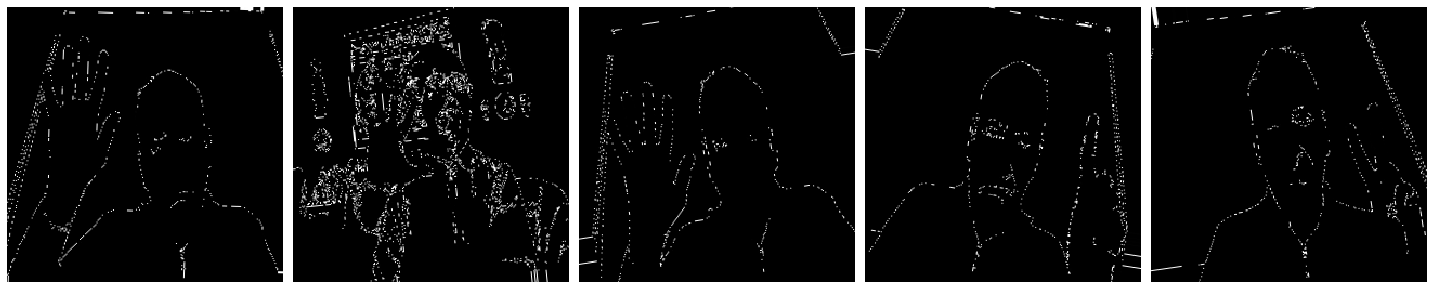

Image 1  one-hot encoded class: [0. 0. 0. 0. 1.]
Image 2  one-hot encoded class: [0. 0. 0. 0. 1.]
Image 3  one-hot encoded class: [0. 0. 0. 0. 1.]
Image 4  one-hot encoded class: [1. 0. 0. 0. 0.]
Image 5  one-hot encoded class: [0. 1. 0. 0. 0.]


In [139]:
plotImages(sample_training_images[:5], sample_training_labels[:5])

In [140]:
sample_training_images[0].shape

(255, 255, 3)

The image is grayscale but for consistency I shall not change anything in the code

In [141]:
print(sample_training_images[0].min(), sample_training_images[0].max())

0.0 1.0


The situation is even better, there are only 2 possible values for a pixel: 0. and 1.

In [142]:
train_data_gen.class_indices

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}

In [143]:
test_data_gen.class_indices

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}

# Model 4, two Conv2D layers with 16 and 32 filters, cv2.Canny

In [144]:
model4 = Sequential()

model4.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', input_shape=image_shape, activation='relu'))
model4.add(MaxPooling2D(pool_size=(3, 3)))
model4.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=(3, 3)))
#model4.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
#model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Flatten())

model4.add(Dense(255))
model4.add(Activation('relu'))

model4.add(Dense(5, activation='softmax'))

model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [145]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 255, 255, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 85, 85, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 85, 85, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 255)               6397695   
_________________________________________________________________
activation_3 (Activation)    (None, 255)              

In [146]:
history = model4.fit_generator(train_data_gen,
                               epochs=epochs,
                               validation_data=test_data_gen,
                               callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1005 steps, validate for 430 steps
Epoch 1/10
1005/1005 [==============================] - 275s 274ms/step - loss: 0.6623 - accuracy: 0.7427 - val_loss: 0.4436 - val_accuracy: 0.8333
Epoch 2/10
1005/1005 [==============================] - 274s 272ms/step - loss: 0.2997 - accuracy: 0.8853 - val_loss: 0.3064 - val_accuracy: 0.8792
Epoch 3/10
1005/1005 [==============================] - 272s 271ms/step - loss: 0.2112 - accuracy: 0.9187 - val_loss: 0.2135 - val_accuracy: 0.9156
Epoch 4/10
1005/1005 [==============================] - 270s 269ms/step - loss: 0.1663 - accuracy: 0.9374 - val_loss: 0.1625 - val_accuracy: 0.9363
Epoch 5/10
1005/1005 [==============================] - 270s 268ms/step - loss: 0.1402 - accuracy: 0.9488 - val_loss: 0.1379 - val_accuracy: 0.9467
Epoch 6/10
1005/1005 [==============================] - 270s 269ms/step - loss: 0.1147 - accuracy: 0.9585 - val_loss: 0.1401 - val_accuracy: 0.9551
Epoch 7/10
1005/1

In [147]:
model4.save('model4-two-CNN-layers-Canny.h5')

In [148]:
losses_model4 = pd.DataFrame(model4.history.history)
losses_model4

,loss,accuracy,val_loss,val_accuracy
0,0.662522,0.742736,0.443608,0.833285
1,0.299835,0.885273,0.306398,0.879215
2,0.211239,0.918746,0.213499,0.915552
3,0.166340,0.937411,0.162498,0.936337
4,0.140274,0.948796,0.137883,0.946657
5,0.114756,0.958502,0.140118,0.955087
6,0.106079,0.960990,0.101784,0.961628
7,0.095107,0.964101,0.138163,0.948692
8,0.078129,0.971754,0.091844,0.967297
9,0.080538,0.970821,0.119703,0.956977


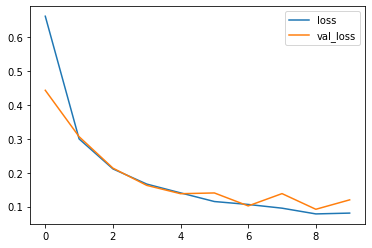

In [149]:
losses_model4[['loss','val_loss']].plot()

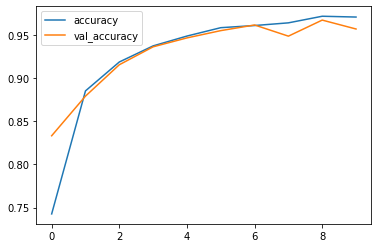

In [150]:
losses_model4[['accuracy','val_accuracy']].plot()

In [151]:
# Model 4 is very similar with model 3 for the train and test datasets.
# Starting from epoch 7, the model tends to overfit and early_stop fired.

In [153]:
model4.metrics_names

['loss', 'accuracy']

In [154]:
model4.evaluate_generator(test_data_gen)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


[0.13038512407358718, 0.95377904]

In [155]:
predictions4 = model4.predict_classes(test1_images)

In [156]:
labels = []
for result in test1_labels:
    labels.append(np.where(result == 1)[0][0])
labels = np.asarray(labels)

In [159]:
print(classification_report(labels, predictions4))

              precision    recall  f1-score   support

           0       0.50      0.03      0.05        40
           1       0.20      0.03      0.04        40
           2       0.00      0.00      0.00        40
           3       0.50      0.05      0.09        40
           4       0.20      0.95      0.33        40

    accuracy                           0.21       200
   macro avg       0.28      0.21      0.10       200
weighted avg       0.28      0.21      0.10       200



In [160]:
confusion_matrix(labels, predictions4)

array([[ 1,  2,  1,  1, 35],
       [ 0,  1,  0,  0, 39],
       [ 1,  1,  0,  0, 38],
       [ 0,  0,  0,  2, 38],
       [ 0,  1,  0,  1, 38]])

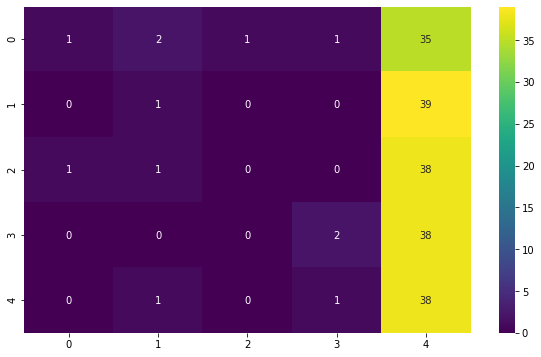

In [161]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(labels, predictions4), cmap='viridis', annot=True)

In [171]:
np.sum(confusion_matrix(labels, predictions4), axis=0)

array([  2,   5,   1,   4, 188])

In [174]:
# The bias is now extreme for class 4

# Model 5 - add one more convolutional layer, use edge images

In [175]:
model5 = Sequential()

model5.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', input_shape=image_shape, activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Flatten())

model5.add(Dense(128))
model5.add(Activation('relu'))

model5.add(Dense(5, activation='softmax'))

model5.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# loss='sparse_categorical_crossentropy'
# optimizer='adam'

In [176]:
#model = Sequential()
#model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
#model.add(MaxPooling2D((2, 2)))
#model.add(Conv2D(64, (3, 3), activation='relu')) 
#model.add(MaxPooling2D((2, 2)))
#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D((2, 2)))
#model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dense(10, activation='softmax'))# Configures the model for training
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

In [177]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 255, 255, 32)      2432      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 63, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 61504)            

In [178]:
history = model5.fit_generator(train_data_gen,
                               epochs=epochs,
                               validation_data=test_data_gen,
                               callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1005 steps, validate for 430 steps
Epoch 1/10
1005/1005 [==============================] - 291s 289ms/step - loss: 0.6547 - accuracy: 0.7477 - val_loss: 0.3683 - val_accuracy: 0.8612
Epoch 2/10
1005/1005 [==============================] - 298s 296ms/step - loss: 0.2951 - accuracy: 0.8882 - val_loss: 0.2786 - val_accuracy: 0.8906
Epoch 3/10
1005/1005 [==============================] - 290s 289ms/step - loss: 0.2178 - accuracy: 0.9179 - val_loss: 0.2011 - val_accuracy: 0.9251
Epoch 4/10
1005/1005 [==============================] - 291s 289ms/step - loss: 0.1697 - accuracy: 0.9387 - val_loss: 0.1427 - val_accuracy: 0.9465
Epoch 5/10
1005/1005 [==============================] - 281s 279ms/step - loss: 0.1369 - accuracy: 0.9491 - val_loss: 0.1192 - val_accuracy: 0.9533
Epoch 6/10
1005/1005 [==============================] - 278s 277ms/step - loss: 0.1150 - accuracy: 0.9589 - val_loss: 0.1482 - val_accuracy: 0.9467
Epoch 7/10
1005/1

In [179]:
model5.save('model5-three-CNN-layers.h5')

In [180]:
losses_model5 = pd.DataFrame(model5.history.history)
losses_model5

,loss,accuracy,val_loss,val_accuracy
0,0.654809,0.747714,0.368291,0.861192
1,0.295207,0.888198,0.278576,0.890552
2,0.217876,0.917937,0.201063,0.925145
3,0.169753,0.938717,0.142691,0.946512
4,0.136940,0.949107,0.119171,0.953343
5,0.115061,0.958937,0.148211,0.946657
6,0.106844,0.960617,0.097418,0.964826
7,0.094968,0.966714,0.104024,0.965988
8,0.086179,0.970572,0.156613,0.953343


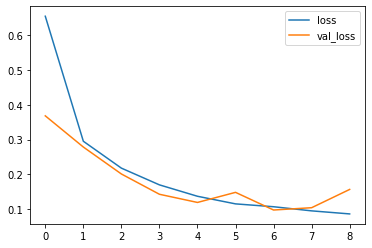

In [181]:
losses_model5[['loss','val_loss']].plot()

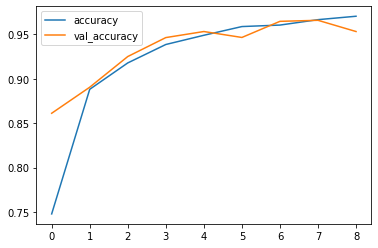

In [182]:
losses_model5[['accuracy','val_accuracy']].plot()

In [183]:
model5.metrics_names

['loss', 'accuracy']

In [184]:
model5.evaluate_generator(test_data_gen)

  ...
    to  
  ['...']


[0.1579452719183046, 0.9536337]

In [185]:
predictions5 = model5.predict_classes(test1_images)

In [186]:
labels = []
for result in test1_labels:
    labels.append(np.where(result == 1)[0][0])
labels = np.asarray(labels)

In [188]:
print(classification_report(labels, predictions5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.14      0.10      0.12        40
           2       0.17      0.03      0.04        40
           3       0.50      0.03      0.05        40
           4       0.21      0.85      0.34        40

    accuracy                           0.20       200
   macro avg       0.20      0.20      0.11       200
weighted avg       0.20      0.20      0.11       200



In [189]:
confusion_matrix(labels, predictions5)

array([[ 0,  6,  2,  0, 32],
       [ 0,  4,  1,  0, 35],
       [ 0,  7,  1,  1, 31],
       [ 1,  6,  2,  1, 30],
       [ 0,  6,  0,  0, 34]])

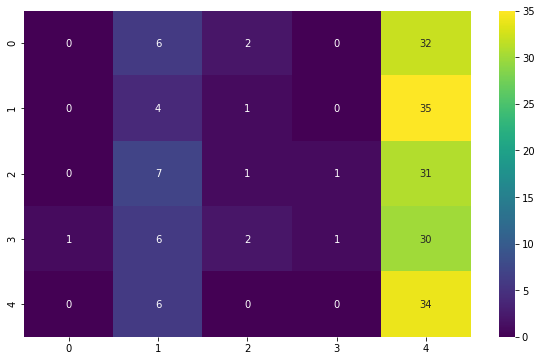

In [190]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(labels, predictions5), cmap='viridis', annot=True)

In [191]:
np.sum(confusion_matrix(labels, predictions5), axis=0)

array([  1,  29,   6,   2, 162])

In [ ]:
# It looks like using edge data for this model do not show an improvement

# Model 6 - model 5 on original data, optimizer = 'adam'

In [290]:
# parameters
train_dir = './data/train'
test_dir = './data/test'
batch_size = 16
epochs = 10
# will rescale all jpeg images to 255x255 for having a reasonable time for the training
IMG_HEIGHT = 255
IMG_WIDTH = 255

image_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

In [291]:
image_gen = ImageDataGenerator(rotation_range=10, # randomly rotate the image with <=10 degrees
                               #width_shift_range=0.10, # Shift the pic width by a max of 10%
                               #height_shift_range=0.10, # Shift the pic height by a max of 10%
                               rescale=1/255, # Normalize the image
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [292]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH)
                                              )

Found 150 images belonging to 5 classes.


In [293]:
test_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                              directory=test_dir,
                                              shuffle=True,
                                              target_size=(IMG_HEIGHT, IMG_WIDTH)
                                             )

Found 6880 images belonging to 5 classes.


In [202]:
model6 = Sequential()

model6.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', input_shape=image_shape, activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

model6.add(Flatten())

model6.add(Dense(128))
model6.add(Activation('relu'))

model6.add(Dense(5, activation='softmax'))

model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [203]:
model6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 255, 255, 32)      2432      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 63, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 61504)            

In [204]:
history = model6.fit_generator(train_data_gen,
                               epochs=epochs,
                               validation_data=test_data_gen,
                               callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1005 steps, validate for 430 steps
Epoch 1/10
1005/1005 [==============================] - 409s 407ms/step - loss: 0.8743 - accuracy: 0.6545 - val_loss: 0.4067 - val_accuracy: 0.8453
Epoch 2/10
1005/1005 [==============================] - 398s 396ms/step - loss: 0.2955 - accuracy: 0.8910 - val_loss: 0.2178 - val_accuracy: 0.9225
Epoch 3/10
1005/1005 [==============================] - 387s 385ms/step - loss: 0.1501 - accuracy: 0.9462 - val_loss: 0.0946 - val_accuracy: 0.9669
Epoch 4/10
1005/1005 [==============================] - 384s 382ms/step - loss: 0.0881 - accuracy: 0.9701 - val_loss: 0.0611 - val_accuracy: 0.9779
Epoch 5/10
1005/1005 [==============================] - 384s 382ms/step - loss: 0.0651 - accuracy: 0.9778 - val_loss: 0.0705 - val_accuracy: 0.9760
Epoch 6/10
1005/1005 [==============================] - 383s 381ms/step - loss: 0.0524 - accuracy: 0.9820 - val_loss: 0.0390 - val_accuracy: 0.9860
Epoch 7/10
1005/1

In [205]:
model6.save('model6-three-CNN-layers.h5')
losses_model6 = pd.DataFrame(model6.history.history)
losses_model6

,loss,accuracy,val_loss,val_accuracy
0,0.874199,0.654514,0.406691,0.845349
1,0.295302,0.890997,0.217829,0.922529
2,0.149836,0.946245,0.094577,0.966860
3,0.087841,0.970074,0.061093,0.977907
4,0.065142,0.977789,0.070517,0.976017
5,0.052280,0.981957,0.038969,0.986046
6,0.035868,0.987806,0.047414,0.984738
7,0.039745,0.987308,0.043392,0.986192


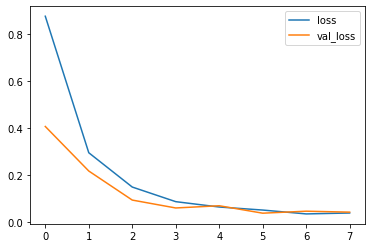

In [206]:
losses_model6[['loss','val_loss']].plot()

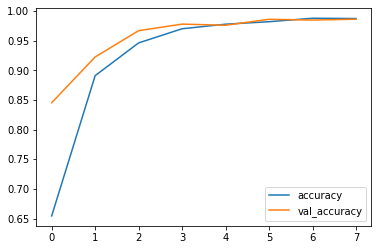

In [207]:
losses_model6[['accuracy','val_accuracy']].plot()

In [208]:
model6.metrics_names

['loss', 'accuracy']

In [209]:
test_loss, test_acc = model6.evaluate_generator(test_data_gen)
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

  ...
    to  
  ['...']


[0.041323107705559164, 0.98735464]

In [211]:
print(classification_report(labels, predictions6))

              precision    recall  f1-score   support

           0       0.12      0.03      0.04        40
           1       0.21      0.20      0.21        40
           2       0.17      0.05      0.08        40
           3       0.20      0.40      0.27        40
           4       0.22      0.35      0.27        40

    accuracy                           0.20       200
   macro avg       0.19      0.20      0.17       200
weighted avg       0.19      0.20      0.17       200



In [212]:
confusion_matrix(labels, predictions6)

array([[ 1,  9,  3, 15, 12],
       [ 2,  8,  2, 16, 12],
       [ 0,  8,  2, 19, 11],
       [ 2,  7,  1, 16, 14],
       [ 3,  6,  4, 13, 14]])

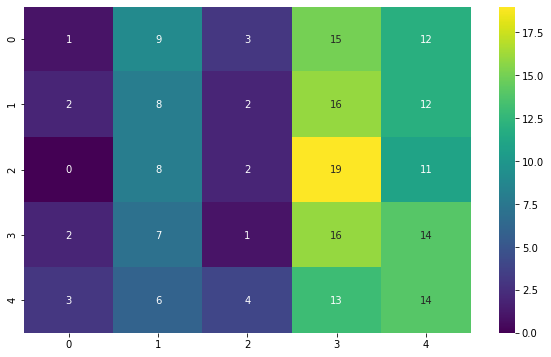

In [213]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(labels, predictions6), cmap='viridis', annot=True)

In [214]:
np.sum(confusion_matrix(labels, predictions6), axis=0)

array([ 8, 38, 12, 79, 63])

In [ ]:
# This is a better model than model 5 even if accuracy is still 20%
# because now the bias is on classes 3 and 4, not just on class 4 as before
# For classes 3 and 4, the highest values are on the diagonal and this is encouraging

# Model 7 - use kernel_size of (5,5), (4,4) and (3,3) for conv layers

In [259]:
model7 = Sequential()

model7.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', input_shape=image_shape, activation='relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))

model7.add(Flatten())

model7.add(Dense(128))
model7.add(Activation('relu'))

model7.add(Dense(5, activation='softmax'))

model7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [260]:
model7.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 255, 255, 32)      2432      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 127, 127, 64)      32832     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 63, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 61504)           

In [261]:
history = model7.fit_generator(train_data_gen,
                               epochs=epochs,
                               validation_data=test_data_gen,
                               callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1014 steps, validate for 430 steps
Epoch 1/10
1014/1014 [==============================] - 390s 385ms/step - loss: 0.8298 - accuracy: 0.6666 - val_loss: 0.3647 - val_accuracy: 0.8667
Epoch 2/10
1014/1014 [==============================] - 386s 381ms/step - loss: 0.2880 - accuracy: 0.8965 - val_loss: 0.1546 - val_accuracy: 0.9474
Epoch 3/10
1014/1014 [==============================] - 387s 381ms/step - loss: 0.1386 - accuracy: 0.9536 - val_loss: 0.0727 - val_accuracy: 0.9750
Epoch 4/10
1014/1014 [==============================] - 387s 382ms/step - loss: 0.0948 - accuracy: 0.9707 - val_loss: 0.0669 - val_accuracy: 0.9808
Epoch 5/10
1014/1014 [==============================] - 386s 381ms/step - loss: 0.0662 - accuracy: 0.9790 - val_loss: 0.0384 - val_accuracy: 0.9882
Epoch 6/10
1014/1014 [==============================] - 386s 381ms/step - loss: 0.0531 - accuracy: 0.9835 - val_loss: 0.0202 - val_accuracy: 0.9937
Epoch 7/10
1014/1

In [262]:
model7.save('model7-three-CNN-layers.h5')
losses_model7 = pd.DataFrame(model7.history.history)
losses_model7

,loss,accuracy,val_loss,val_accuracy
0,0.829805,0.666646,0.364718,0.866715
1,0.287973,0.896505,0.154596,0.947384
2,0.138564,0.953584,0.072693,0.975000
3,0.094769,0.970721,0.066916,0.980814
4,0.066226,0.978980,0.038425,0.988227
5,0.053073,0.983480,0.020180,0.993750
6,0.044289,0.986501,0.030577,0.990988
7,0.040062,0.986994,0.032797,0.990262


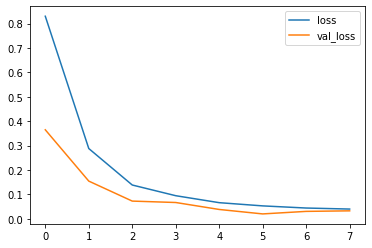

In [263]:
losses_model7[['loss','val_loss']].plot()

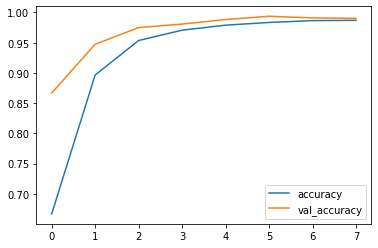

In [264]:
losses_model7[['accuracy','val_accuracy']].plot()

In [265]:
test_loss, test_acc = model7.evaluate_generator(test_data_gen)
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

  ...
    to  
  ['...']
Test accuracy: 99.07%


In [267]:
print(classification_report(labels, predictions7))

              precision    recall  f1-score   support

           0       0.71      0.42      0.53        40
           1       0.42      0.55      0.48        40
           2       0.56      0.55      0.56        40
           3       0.34      0.45      0.39        40
           4       0.62      0.50      0.56        40

    accuracy                           0.49       200
   macro avg       0.53      0.49      0.50       200
weighted avg       0.53      0.49      0.50       200



In [268]:
confusion_matrix(labels, predictions7)

array([[17,  7,  4,  9,  3],
       [ 2, 22,  4, 11,  1],
       [ 0,  9, 22,  8,  1],
       [ 2,  8,  5, 18,  7],
       [ 3,  6,  4,  7, 20]])

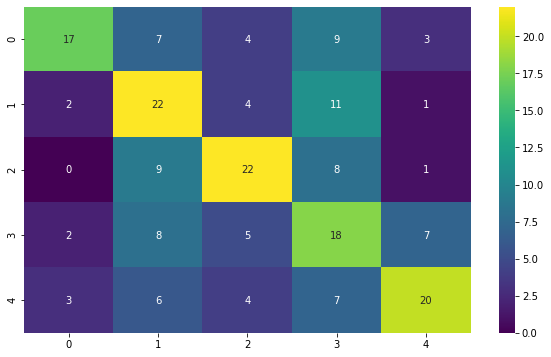

In [269]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(labels, predictions7), cmap='viridis', annot=True)

In [271]:
# This result is the best I could get

# Next idea: use the previous model with cv2.Canny

In [11]:
# parameters
train_dir = './data_edges/train'
test_dir = './data_edges/test'
batch_size = 16
epochs = 10
# will rescale all jpeg images to 255x255 for having a reasonable time for the training
IMG_HEIGHT = 255
IMG_WIDTH = 255

image_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

In [12]:
image_gen = ImageDataGenerator(rotation_range=10, # randomly rotate the image with <=10 degrees
                               #width_shift_range=0.10, # Shift the pic width by a max of 10%
                               #height_shift_range=0.10, # Shift the pic height by a max of 10%
                               rescale=1/255, # Normalize the image
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [13]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH)
                                              )

Found 10061 images belonging to 5 classes.


In [14]:
test_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                              directory=test_dir,
                                              shuffle=True,
                                              target_size=(IMG_HEIGHT, IMG_WIDTH)
                                             )

Found 4303 images belonging to 5 classes.


In [29]:
test1_dir = './data_edges/test1'
batch_size = 200

test1_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=test1_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH)
                                              )

test1_images, test1_labels = next(test1_data_gen)

Found 100 images belonging to 5 classes.


In [18]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [19]:
model10 = Sequential()

model10.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', input_shape=image_shape, activation='relu'))
model10.add(MaxPooling2D(pool_size=(2, 2)))
model10.add(Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu'))
model10.add(MaxPooling2D(pool_size=(2, 2)))
model10.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model10.add(MaxPooling2D(pool_size=(2, 2)))

model10.add(Flatten())

model10.add(Dense(128))
model10.add(Activation('relu'))

model10.add(Dense(5, activation='softmax'))

model10.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
model10.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 255, 255, 32)      2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 127, 127, 64)      32832     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 63, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 61504)            

In [21]:
history = model10.fit_generator(train_data_gen,
                                epochs=epochs,
                                validation_data=test_data_gen,
                                callbacks=[early_stop])

Epoch 1/10
629/629 [==============================] - 3976s 6s/step - loss: 0.3360 - accuracy: 0.8783 - val_loss: 0.1145 - val_accuracy: 0.9598
Epoch 2/10
629/629 [==============================] - 4416s 7s/step - loss: 0.0750 - accuracy: 0.9738 - val_loss: 0.0563 - val_accuracy: 0.9784
Epoch 3/10
629/629 [==============================] - 4862s 8s/step - loss: 0.0463 - accuracy: 0.9847 - val_loss: 0.0998 - val_accuracy: 0.9705
Epoch 4/10
629/629 [==============================] - 4424s 7s/step - loss: 0.0378 - accuracy: 0.9884 - val_loss: 0.0321 - val_accuracy: 0.9905
Epoch 5/10
629/629 [==============================] - 4888s 8s/step - loss: 0.0296 - accuracy: 0.9903 - val_loss: 0.0268 - val_accuracy: 0.9916
Epoch 6/10
629/629 [==============================] - 4680s 7s/step - loss: 0.0234 - accuracy: 0.9924 - val_loss: 0.0293 - val_accuracy: 0.9888
Epoch 7/10
629/629 [==============================] - 12799s 20s/step - loss: 0.0231 - accuracy: 0.9918 - val_loss: 0.0246 - val_accurac

In [22]:
model10.save('model10-edge-original-test-images.h5')
losses_model10 = pd.DataFrame(model10.history.history)
losses_model10

,loss,accuracy,val_loss,val_accuracy
0,0.335905,0.878342,0.114537,0.959795
1,0.074996,0.973760,0.056317,0.978387
2,0.046294,0.984693,0.099819,0.970486
3,0.037811,0.988371,0.032144,0.990472
4,0.029654,0.990259,0.026840,0.991634
5,0.023447,0.992446,0.029338,0.988845
6,0.023069,0.991850,0.024612,0.992331
7,0.018270,0.994732,0.039596,0.988845
8,0.026789,0.990955,0.020342,0.992099
9,0.012655,0.996521,0.038314,0.986753


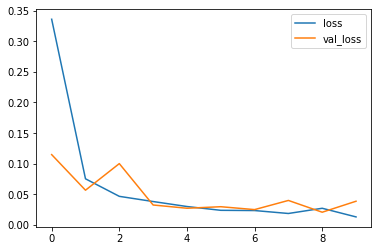

In [23]:
losses_model10[['loss','val_loss']].plot()

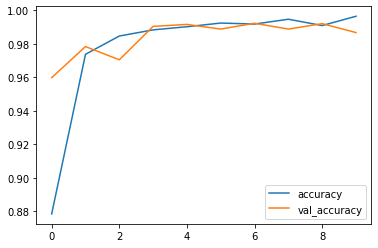

In [24]:
losses_model10[['accuracy','val_accuracy']].plot()

In [25]:
test_loss, test_acc = model10.evaluate_generator(test_data_gen)
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

Test accuracy: 98.70%


In [31]:
print(classification_report(labels, predictions10))

              precision    recall  f1-score   support

           0       0.50      0.05      0.09        20
           1       0.19      0.20      0.20        20
           2       0.00      0.00      0.00        20
           3       0.20      0.60      0.30        20
           4       0.27      0.15      0.19        20

    accuracy                           0.20       100
   macro avg       0.23      0.20      0.16       100
weighted avg       0.23      0.20      0.16       100



In [32]:
confusion_matrix(labels, predictions10)

array([[ 1,  5,  1, 13,  0],
       [ 1,  4,  0, 13,  2],
       [ 0,  7,  0, 11,  2],
       [ 0,  2,  2, 12,  4],
       [ 0,  3,  2, 12,  3]])

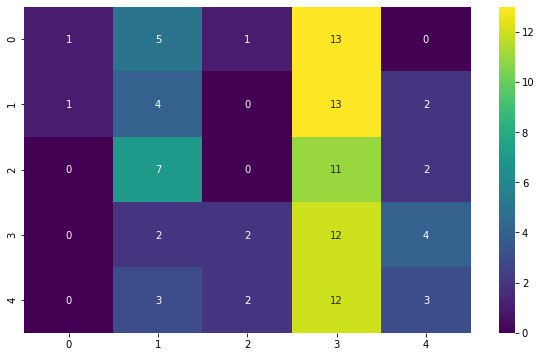

In [33]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(labels, predictions10), cmap='viridis', annot=True)

In [2]:
# The result is not good. Therefore, model 7 remains the best model 
# that can predict with 50% accuracy the number of raised fingers for a person
# from a random Internet image